In [87]:
import numpy as np
import torch
import torchvision
# import cv2
import base64
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.patches as patches
import torch.nn as nn
import random

In [88]:
# Set seeds for reproducibility
seed_value = 42

# Set PyTorch seed
torch.manual_seed(seed_value)

# Set NumPy seed
np.random.seed(seed_value)
random.seed(seed_value)

# If using CUDA (GPU), set the following flag
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  # Disable benchmark mode for deterministic results
torch.cuda.manual_seed_all(seed_value)

In [89]:

class mnist_dataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        self.grid_size = 56
        self.num_classes = 10
    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self,index):
        grid_labels = torch.zeros((5+self.num_classes)) 
        class_rank_start = 5 #the first 5 are reserved for object_found_probability and bounding box coordinates
        image, label = self.original_dataset[index]
        grid_labels[class_rank_start+label] = 1
        image = self.inject_matrix(image)
        box_center_h, box_center_w, box_h, box_w = self.coordinates_calculation_relative_2_image(image)
        grid_image, grid_labels = self.labels_per_grid(image,box_center_h, box_center_w, box_h, box_w, grid_labels)
        grid_image = grid_image[np.newaxis,:]
        return grid_image, grid_labels

    def inject_matrix(self,smaller_tensor):
        # Get the shape of the matrices
        # Create a larger tensor of size (200, 700) filled with zeros
        larger_tensor = np.zeros((56,56), dtype=np.float32)

        # target_size = (150, 150)
        # smaller_tensor = smaller_tensor.unsqueeze(0)
        # # Use torch.nn.functional.interpolate to resize the tensor
        # smaller_tensor = F.interpolate(smaller_tensor, size=target_size, mode='bilinear', align_corners=False)
        smaller_tensor = smaller_tensor.squeeze()
        # Get the dimensions of the smaller tensor
        smaller_rows, smaller_cols = smaller_tensor.shape
        
        # Generate random starting coordinates within the valid range
        row_start = np.random.randint(0, larger_tensor.shape[0] - smaller_rows + 1)
        col_start = np.random.randint(0, larger_tensor.shape[1] - smaller_cols + 1)
        
        # Inject the smaller tensor into the larger tensor at the random location
        larger_tensor[row_start:row_start + smaller_rows, col_start:col_start + smaller_cols] = smaller_tensor
        return larger_tensor[np.newaxis,:]
    
    def coordinates_calculation_relative_2_image(self,image):
        h_min = np.Inf
        h_max = -1
        w_min = np.Inf
        w_max = -1
        h_image = image.shape[1]
        w_image = image.shape[2]
        min_found = 0
        for i_h in range(h_image):
            for i_w in range(w_image):
                if image[:,i_h,i_w] != 0:
                    if h_min > i_h:
                        h_min = i_h
                    if w_min > i_w:
                        w_min = i_w
                    if h_min > -1 and i_h > h_max:
                        h_max = i_h
                    if w_min > -1 and i_w > w_max:
                        w_max = i_w
        box_h = h_max - h_min
        box_w = w_max - w_min
        box_center_h = h_min + 0.5*box_h
        box_center_w = w_min + 0.5*box_w
        return box_center_h, box_center_w, box_h, box_w
    
    def labels_per_grid(self,image,box_center_h, box_center_w, box_h, box_w, grid_labels):
        num_of_grids = image.shape[1]//self.grid_size
        for i_grid in range(num_of_grids):
            grid_start = i_grid * self.grid_size
            grid_end = (i_grid+1) * self.grid_size
            grid_image = image[0,grid_start:grid_end,grid_start:grid_end]
            grid_box_center_h, grid_box_center_w, grid_box_h, grid_box_w = self.coordinates_calculation_relative_2_grid(grid_image,box_center_h, box_center_w, box_h, box_w)
            grid_labels[1:5] = torch.tensor([grid_box_center_h, grid_box_center_w, grid_box_h, grid_box_w]) 
        if box_center_h > grid_start and box_center_w > grid_start and box_center_h < grid_end and box_center_w < grid_end:
            grid_labels[0] = 1
        return grid_image, grid_labels #torch.tensor([grid_box_center_h, grid_box_center_w, grid_box_h, grid_box_w])
            
    
    def coordinates_calculation_relative_2_grid(self, grid_image,box_center_h, box_center_w, box_h, box_w):
        grid_box_center_h = box_center_h/self.grid_size
        grid_box_center_w = box_center_w/self.grid_size
        grid_box_h = box_h / self.grid_size
        grid_box_w = box_w / self.grid_size
        return grid_box_center_h, grid_box_center_w, grid_box_h, grid_box_w
        
        

    






In [90]:
class MyCnn(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
      torch.nn.ReLU(),
      torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
      torch.nn.ReLU(),
      torch.nn.Dropout2d(p=0.1)
    )
    self.conv2 = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
      torch.nn.ReLU(),
      torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
      torch.nn.ReLU(),
      torch.nn.Dropout2d(p=0.1)
    )
    self.linear_relu_stack = torch.nn.Sequential(
      torch.nn.Flatten(),
      torch.nn.Linear(in_features=147456, out_features=128),
      torch.nn.ReLU(),
      torch.nn.Dropout(p=0.1),
      torch.nn.Linear(in_features=128, out_features=15)
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    logits = self.linear_relu_stack(x)
    return logits

In [91]:
def draw_box(image, box_center_h, box_center_w, box_height, box_width):
    fig, ax = plt.subplots(1)
    box_center_h =np.floor(box_center_h * train_ds.grid_size)
    box_center_w =np.floor(box_center_w*train_ds.grid_size)
    box_height =np.floor(box_height*train_ds.grid_size)
    box_width =np.floor(box_width*train_ds.grid_size)
    print(box_center_h, box_center_w, box_height, box_width)
    y_min = box_center_h - 0.5 * box_height
    x_min = box_center_w - 0.5 * box_width

    # Display the image
    ax.imshow(np.array(image[0,:,:]))
    rect = patches.Rectangle((x_min, y_min), box_width, box_height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()

torch.Size([10, 1, 56, 56])
torch.Size([10, 15])
39.0 16.0 18.0 17.0


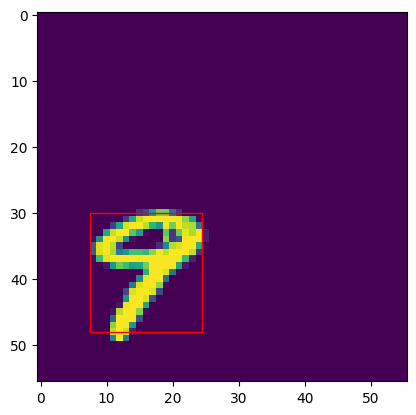

In [92]:
train_ds = torchvision.datasets.MNIST(root="data", train=True,  download=True, transform=torchvision.transforms.ToTensor())
train_ds = mnist_dataset(train_ds)
test_ds = torchvision.datasets.MNIST(root="data", train=False,  download=True, transform=torchvision.transforms.ToTensor())
test_ds = mnist_dataset(test_ds)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=10)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=10)
i_batch = 9
for batch in test_dl:
    # print(batch[0].squeeze().size())
    # mnist_image = batch[0].squeeze()
    a,b = batch
    print(a.shape)
    print(b.shape)
    draw_box(a[i_batch], b[i_batch,1].item(),b[i_batch,2].item(),b[i_batch,3].item(),b[i_batch,4].item())
    
    # a = a.unsqueeze(0)
    # a = F.interpolate(a, size=(28,28), mode='bilinear', align_corners=False)
    # plt.figure()
    # plt.imshow(a.squeeze().squeeze())
    break

In [93]:


class YOLOLoss(nn.Module):
    def __init__(self, num_classes=10, lambda_coord=5.0, lambda_noobj=0.5):
        super(YOLOLoss, self).__init__()
        self.num_classes = num_classes
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj

    def forward(self, predictions, targets):
        """
        Calculate YOLO loss.

        Args:
        - predictions: Tensor of shape (batch_size, 15, S, S)
        - targets: Tensor of shape (batch_size, 15, S, S)

        Returns:
        - loss: Scalar tensor representing the total YOLO loss.
        """
        # Extract predicted and target values
        pred_coords = predictions[:, 1:5]
        pred_obj_prob = predictions[:, 0]
        pred_class_probs = nn.functional.softmax(predictions[:, 5:], dim = 1)
        pred_class_probs = torch.argmax(pred_class_probs, dim = 1)
        
        
        target_coords = targets[:, 1:5]
        target_obj_prob = targets[:, 0]
        target_class_probs = targets[:, 5:]
        target_class_probs = torch.argmax(target_class_probs, dim = 1)
        

        
        # Calculate localization loss
        loc_loss = torch.sum((pred_coords - target_coords)**2)
        
        # Calculate confidence loss (object present)
        obj_mask = target_obj_prob > 0
        conf_loss_obj = torch.sum((pred_obj_prob[obj_mask] - target_obj_prob[obj_mask])**2)
        
        # Calculate confidence loss (object not present)
        noobj_mask = target_obj_prob == 0
        conf_loss_noobj = torch.sum((pred_obj_prob[noobj_mask])**2)
        
        # Calculate class prediction loss
        class_loss = torch.sum((pred_class_probs - target_class_probs)**2)
        
        # Combine the individual loss terms
        loss = (
            self.lambda_coord * loc_loss +
            conf_loss_obj +
            self.lambda_noobj * conf_loss_noobj +
            class_loss
        )
        # print(pred_coords)
        # print(target_coords)
        # print(pred_obj_prob)
        # print(target_obj_prob)
        # print(pred_class_probs)
        # print(target_class_probs)
        # print(f'loc_loss = {loc_loss}')
        # print(f'conf_loss_obj = {conf_loss_obj}')
        # print(f'conf_loss_noobj = {conf_loss_noobj}')
        # print(f'class_loss = {class_loss}')
        return loss

# # Example usage:
# S = 1  # Number of grid cells in each dimension
# num_classes = 10  # Number of classes

# # Create a YOLOLoss instance
# yolo_loss = YOLOLoss(num_classes=num_classes)

# # Example predictions and targets (replace with your actual tensors)
# predictions = torch.randn((1, 15, S, S))
# targets = torch.randn((1, 15, S, S))

# # Calculate the loss
# loss = yolo_loss(predictions, targets)

# # Print the loss
# print("Total YOLO Loss:", loss.item())


In [98]:

device = "cuda" if torch.cuda.is_available() else "cpu"

train_ds = torchvision.datasets.MNIST(root="data", train=True,  download=True, transform=torchvision.transforms.ToTensor())
train_ds = mnist_dataset(train_ds)


# subset_indices = list(range(1))
# train_ds = Subset(train_ds,subset_indices)


test_ds = torchvision.datasets.MNIST(root="data", train=False,  download=True, transform=torchvision.transforms.ToTensor())
test_ds = mnist_dataset(test_ds)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=1, shuffle=False, worker_init_fn=np.random.seed(seed_value))
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False)

myCnn = MyCnn().to(device)
loss = YOLOLoss()
opt = torch.torch.optim.Adam(myCnn.parameters(), lr=1e-4)

for t in range(30):
    for idx, (x, y) in enumerate(train_dl):
      x, y = x.to(device), y.to(device)
      logits = myCnn(x)
      l = loss(logits, y)
      opt.zero_grad()
      l.backward()
      opt.step()
      if idx % 50 == 0: print(f"Epoch: {t}, Loss: {l.item()}")
      break
#     with torch.no_grad():
#       correct = 0
#       total = 0
#       for x, y in test_dl:
#         x, y = x.to(device), y.to(device)
#         logits = myCnn(x)
#         class_prediction = nn.functional.softmax(logits[5:], dim=1)
        
#         total += y.size(0)
#         correct += (pred == y).sum().item()
#       print(f"Epoch: {t}, Accuracy: {correct/total}")
#     torch.save(myCnn.state_dict(), f"./mnist-{t}.pt")


Epoch: 0, Loss: 4.680903911590576
Epoch: 1, Loss: 4.688390254974365
Epoch: 2, Loss: 17.540124893188477
Epoch: 3, Loss: 3.041566848754883
Epoch: 4, Loss: 1.8201220035552979
Epoch: 5, Loss: 16.673227310180664
Epoch: 6, Loss: 17.118776321411133
Epoch: 7, Loss: 0.6560006141662598
Epoch: 8, Loss: 18.762380599975586
Epoch: 9, Loss: 2.7761905193328857
Epoch: 10, Loss: 0.5622963905334473
Epoch: 11, Loss: 1.8948942422866821
Epoch: 12, Loss: 1.4796454906463623
Epoch: 13, Loss: 0.7481289505958557
Epoch: 14, Loss: 0.5960142016410828
Epoch: 15, Loss: 0.9593182802200317
Epoch: 16, Loss: 1.7659567594528198
Epoch: 17, Loss: 1.4323042631149292
Epoch: 18, Loss: 0.6406248211860657
Epoch: 19, Loss: 0.8848147988319397
Epoch: 20, Loss: 1.5727229118347168
Epoch: 21, Loss: 0.14302656054496765
Epoch: 22, Loss: 0.21472255885601044
Epoch: 23, Loss: 0.12301971018314362
Epoch: 24, Loss: 0.2869252860546112
Epoch: 25, Loss: 1.0032488107681274
Epoch: 26, Loss: 1.3012837171554565
Epoch: 27, Loss: 0.28299251198768616
E

17.0 37.0 18.0 18.0


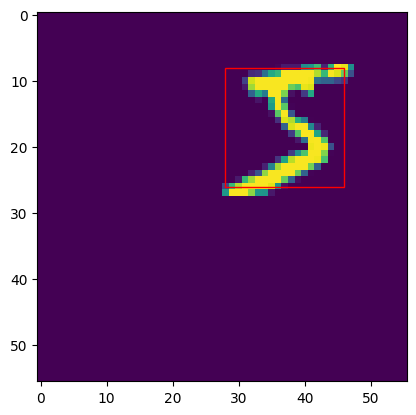

In [99]:
i_batch = 0
b = logits
b.cpu()
images = x
images.cpu()
draw_box(x[i_batch].cpu(), y[i_batch,1].item(),y[i_batch,2].item(),y[i_batch,3].item(),y[i_batch,4].item())


36.0 40.0 15.0 24.0


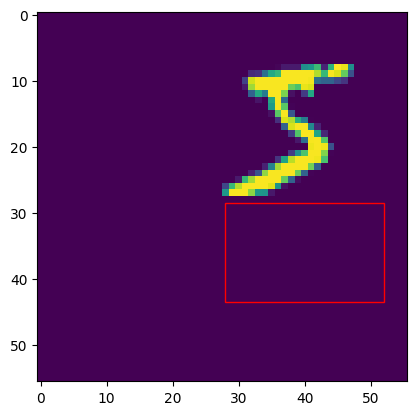

In [100]:
draw_box(images[i_batch].cpu(), b[i_batch,1].item(),b[i_batch,2].item(),b[i_batch,3].item(),b[i_batch,4].item())

In [101]:
with torch.no_grad():
  correct = 0
  total = 0
  for x, y in test_dl:
    x, y = x.to(device), y.to(device)
    logits = myCnn(x)
    class_prediction = nn.functional.softmax(logits[:,5:], dim=1)
    break

In [102]:
i_batch = 2
print(torch.argmax(class_prediction,dim=1))
draw_box(x[i_batch].cpu(), y[i_batch,1].item(),y[i_batch,2].item(),y[i_batch,3].item(),y[i_batch,4].item())

tensor([5], device='cuda:0')


IndexError: index 2 is out of bounds for dimension 0 with size 1

In [103]:
b = logits
b.cpu()
images = x
images.cpu()
draw_box(images[i_batch].cpu(), b[i_batch,1].item(),b[i_batch,2].item(),b[i_batch,3].item(),b[i_batch,4].item())

IndexError: index 2 is out of bounds for dimension 0 with size 1

In [104]:
b[500,:5]

IndexError: index 500 is out of bounds for dimension 0 with size 1

In [285]:
def calculate_accuracy(predictions, ground_truths, iou_threshold=0.5, confidence_threshold=0.5):
    total_predictions = len(predictions)
    correct_count = count_correct_predictions(predictions, ground_truths, iou_threshold, confidence_threshold)
    accuracy = correct_count / total_predictions if total_predictions > 0 else 0
    return accuracy


def count_correct_predictions(predictions, ground_truths, iou_threshold=0.5, confidence_threshold=0.5):
    correct_count = 0

    for pred in predictions:
        # Apply confidence threshold
        if pred[0] < confidence_threshold:
            continue

        # Find the ground truth with the highest IoU
        max_iou = max([calculate_iou(pred[1:5], gt[1:5]) for gt in ground_truths], default=0)

        # Check if the prediction is correct
        if max_iou >= iou_threshold:
            correct_count += 1

    return correct_count



In [303]:
for l in logits:
    print(l)
    break

tensor([ 1.7516,  1.0619,  1.0562,  0.6489,  0.3899, -0.4800, -0.4021, -0.4931,
        -0.4704, -0.4903, -0.5522, -0.5027, -0.4627, -0.4931, -0.4939],
       device='cuda:0')
